In [1]:
import os 
import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.models import Sequential 
from keras import layers
from keras.optimizers import RMSprop

%matplotlib inline

c:\users\ian\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
path = os.path.join('jena_climate_2009_2016', 'jena_climate_2009_2016.csv')
f = open(path)
data = f.read()
f.close()

In [3]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [86]:
float_data = np.zeros((len(lines), len(header) -1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

### Making a simple graph of celcius temperature

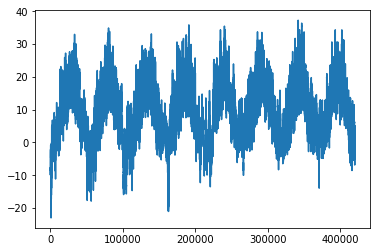

In [87]:
temp = float_data[:,1]
plt.plot(range(len(temp)), temp)
plt.show()

#### $\bullet$It is clear to see a yearly trend in the temperature

#### $\bullet$ Data is recorded every 10 minutes, thus you get 144 data ponits per day

#### $\bullet$ Lets take a look at the first ten days

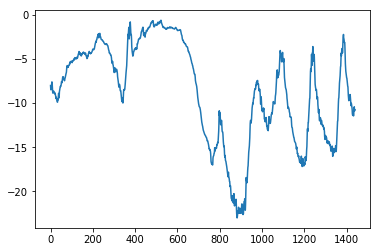

In [88]:
plt.plot(range(1440), temp[:1440])
plt.show()

## Preparing the data

#### $\bullet$ Given data going back $\bf{loopback}$ timesteps

#### $\bullet$ Data is sampled every $\bf{steps}$ timesteps

#### $\bullet$ Can you predict the temperature in $\bf{delay}$ timesteps

In [89]:
# Using the first 200,000 timesteps as training data
# Compute both the mean and std
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [90]:
float_data.shape[-1]

14

In [100]:
# Creating a generator for the data
def generator(data,lookback, delay, min_index, max_index,shuffle=False, batch_size=128, step=6):
    '''
    data: Original array of float data (normalized)
    lookback: Timesteps back the input data should go
    delay: timesteps in the future target should be
    min_index & max_index: Indicies in that data that delimit which 
        timesteps to draw from
    shuffle: Whether to shuffle that data
    batch_size: The number of samples per batch
    step: The period, in timesteps, at which you sample the data.
        Setting it to a value of six draws one data point per hour
        
    Yields a tuple (samples, targets)
        samples is one batch of input data
        targets is the corresponding array of target temperatures
    '''
    
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback 
    
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i+batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows), ))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

#### Python Generators

In [98]:
def generator():
    i = 0
    while True:
        i += 1
        yield i
for item in generator():
    print(item)
    if item > 4:
        break

1
2
3
4
5


In [99]:
## Creating the data generator 
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
lookback=lookback,
delay=delay,
min_index=0,
max_index=200000,
shuffle=True,
step=step,
batch_size=batch_size)

val_gen = generator(float_data,
lookback=lookback,
delay=delay,
min_index=200001,
max_index=300000,
step=step,
batch_size=batch_size)

test_gen = generator(float_data,
lookback=lookback,
delay=delay,
min_index=300001,
max_index=None,
step=step,
batch_size=batch_size)

# How many steps to draw from val_gen in order to see the entire 
# validation set
val_steps = (300000 - 200001 - lookback)

# How many steps to draw from test_gen in order to see the entire
# test set
test_steps = (len(float_data) - 300001 - lookback)

TypeError: generator() got an unexpected keyword argument 'lookback'

## Attempt a baseline "common-sense model"

#### $\bullet$ Running the below function takes too long, the overall mean shoudl be 0.29

In [67]:
# def evaluate_naive_method():
#     batch_maes = []
#     for step in tqdm(range(val_steps)):
#         samples, targets = next(val_gen)
#         preds = samples[:, -1, 1]
#         mae = np.mean(np.abs(preds - targets))
#         batch_maes.append(mae)
#     print(np.mean(batch_maes))
# evaluate_naive_method()

## Basic ML Approach

In [70]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback//step, 
                                     float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

In [73]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
steps_per_epoch=500,
epochs=2,
validation_data=val_gen,
validation_steps=val_steps)

Epoch 1/2
499/500 [============================>.] - ETA: 34:23 - loss: 1.26 - ETA: 17:27 - loss: 8.05 - ETA: 4:21 - loss: 4.9902 - ETA: 2:29 - loss: 3.993 - ETA: 1:39 - loss: 3.418 - ETA: 1:17 - loss: 3.173 - ETA: 1:03 - loss: 2.977 - ETA: 53s - loss: 2.802 - ETA: 47s - loss: 2.70 - ETA: 43s - loss: 2.63 - ETA: 40s - loss: 2.56 - ETA: 36s - loss: 2.50 - ETA: 33s - loss: 2.44 - ETA: 30s - loss: 2.37 - ETA: 28s - loss: 2.31 - ETA: 26s - loss: 2.26 - ETA: 24s - loss: 2.21 - ETA: 22s - loss: 2.17 - ETA: 21s - loss: 2.13 - ETA: 20s - loss: 2.10 - ETA: 19s - loss: 2.06 - ETA: 18s - loss: 2.03 - ETA: 17s - loss: 2.00 - ETA: 16s - loss: 1.97 - ETA: 15s - loss: 1.94 - ETA: 14s - loss: 1.91 - ETA: 14s - loss: 1.89 - ETA: 13s - loss: 1.87 - ETA: 13s - loss: 1.84 - ETA: 12s - loss: 1.82 - ETA: 12s - loss: 1.81 - ETA: 11s - loss: 1.79 - ETA: 11s - loss: 1.77 - ETA: 11s - loss: 1.76 - ETA: 10s - loss: 1.74 - ETA: 10s - loss: 1.72 - ETA: 10s - loss: 1.71 - ETA: 9s - loss: 1.6923 - ETA: 9s - loss: 1.

StopIteration: 